# 任务：根据十分钟内报价和交易数据来预测该时间段内股票波动率

## 评价指标

In [68]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import clean
import os
import glob
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import KFold
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 300)
from tqdm import tqdm


path = 'D:/data/optiver/'
train = clean.reduce_mem_usage(pd.read_csv(path+'train.csv'))
test = clean.reduce_mem_usage(pd.read_csv(path+'test.csv'))

内存占用9.82 MB
优化后内存为: 2.86 MB
内存使用减少 70.8%
内存占用0.00 MB
优化后内存为: 0.00 MB
内存使用减少 21.0%


In [5]:
train.target.describe()

count    428932.000000
mean          0.003883
std           0.002930
min           0.000105
25%           0.002026
50%           0.003048
75%           0.004738
max           0.070312
Name: target, dtype: float64

In [61]:
def calc_wap1(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap2(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def for_joblib(name,t='train'):
    name = str(name)
    book_example = clean.reduce_mem_usage(pd.read_parquet(path+'/book_{}.parquet/'.format(t)+'stock_id='+name))
    trade_example =  clean.reduce_mem_usage(pd.read_parquet(path+'/trade_{}.parquet/'.format(t)+'stock_id='+name))
    book_example['wap1'] = calc_wap1(book_example)
    book_example['wap2'] = calc_wap2(book_example)
    trade_example['amount'] = trade_example['price']*trade_example['size']
    trade_example['mean_amount'] = trade_example['amount']/trade_example['size']
    
    # 第一价格下买方力量
    book_example['bid_amount1'] = book_example['bid_price1'] * book_example['bid_size1']
    # 第二价格下买方力量
    book_example['bid_amount2'] = book_example['bid_price2'] * book_example['bid_size2']
    # 第一价格下卖方力量
    book_example['ask_amount1'] = book_example['ask_price1'] * book_example['ask_size1']
    # 第二价格下卖方力量
    book_example['ask_amount2'] = book_example['ask_price2'] * book_example['ask_size2']

    # 第一价格下买卖价差
    book_example['bid_price1-ask_price1'] = book_example['bid_price1']-book_example['ask_price1']
    # 第二价格下买卖价差
    book_example['bid_price2-ask_price2'] = book_example['bid_price2']-book_example['ask_price2']
    # 第一价格下买卖数量差
    book_example['bid_size1-ask_size1'] = book_example['bid_size1']-book_example['ask_size1']
    # 第二价格下买卖数量差
    book_example['bid_size2-ask_size2'] = book_example['bid_size2']-book_example['ask_size2']


    # 第一价格下买卖力量差
    book_example['bid_amount1-ask_amount1'] = book_example['bid_amount1']-book_example['ask_amount1']
    # 第二价格下买卖力量差
    book_example['bid_amount2-ask_amount2'] = book_example['bid_amount2']-book_example['ask_amount2']

    book_trade_example = pd.merge(book_example,trade_example,on=['time_id','seconds_in_bucket'],how='left')
    
    book_trade = pd.DataFrame()
    book_trade['time_id'] = book_example['time_id'].unique()

    for col in [column for column in book_example.columns if column not in ['time_id','seconds_in_bucket']]:
        data = book_trade_example.groupby('time_id',as_index=False)[col].agg({'{}_sum'.format(col):'sum',
                                                                 '{}_mean'.format(col):'mean',
                                                                '{}_median'.format(col):'median',
                                                                 '{}_max'.format(col):'max',
                                                                 '{}_min'.format(col):'min',
                                                                 '{}_std'.format(col):'std'})
        book_trade = pd.merge(book_trade,data,on = 'time_id',how='left')
        
    
    book_trade['stock_id'] = int(name)
    book_trade['row_id'] = book_trade['stock_id'].astype('str') + '-'+ book_trade['time_id'].astype(str)
    return book_trade


#####################################################################################################

from joblib import Parallel,delayed
list_stock_ids = train.stock_id.unique().tolist()
data = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids) 
data = pd.concat(data, ignore_index = True)

train = train.merge(data,on=['stock_id','time_id'],how='left')
train.to_parquet(path+'train_book_trade.parquet',index=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  3.7min finished


## 测试集

In [5]:
book_example = pd.read_parquet(path+'/book_train.parquet/stock_id=0')
trade_example = pd.read_parquet(path+'/trade_train.parquet/stock_id=0')

In [34]:
def ret(data):
    return data.price.iloc[-1]/data.price.iloc[0]-1

In [38]:
train

,stock_id,time_id,target
0,0,5,0.004135
1,0,11,0.001445
2,0,16,0.002169
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003460
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


In [7]:
test.head()

,stock_id,time_id,row_id,bid_price1_sum,bid_price1_mean,bid_price1_median,bid_price1_max,bid_price1_min,bid_price1_std,ask_price1_sum,ask_price1_mean,ask_price1_median,ask_price1_max,ask_price1_min,ask_price1_std,bid_price2_sum,bid_price2_mean,bid_price2_median,bid_price2_max,bid_price2_min,bid_price2_std,ask_price2_sum,ask_price2_mean,ask_price2_median,ask_price2_max,ask_price2_min,ask_price2_std,bid_size1_sum,bid_size1_mean,bid_size1_median,bid_size1_max,bid_size1_min,bid_size1_std,ask_size1_sum,ask_size1_mean,ask_size1_median,ask_size1_max,ask_size1_min,ask_size1_std,bid_size2_sum,bid_size2_mean,bid_size2_median,bid_size2_max,bid_size2_min,bid_size2_std,ask_size2_sum,ask_size2_mean,ask_size2_median,ask_size2_max,ask_size2_min,ask_size2_std,bid_amount1_sum,bid_amount1_mean,bid_amount1_median,bid_amount1_max,bid_amount1_min,bid_amount1_std,bid_amount2_sum,bid_amount2_mean,bid_amount2_median,bid_amount2_max,bid_amount2_min,bid_amount2_std,ask_amount1_sum,ask_amount1_mean,ask_amount1_median,ask_amount1_max,ask_amount1_min,ask_amount1_std,ask_amount2_sum,ask_amount2_mean,ask_amount2_median,ask_amount2_max,ask_amount2_min,ask_amount2_std,bid_price1-ask_price1_sum,bid_price1-ask_price1_mean,bid_price1-ask_price1_median,bid_price1-ask_price1_max,bid_price1-ask_price1_min,bid_price1-ask_price1_std,bid_price2-ask_price2_sum,bid_price2-ask_price2_mean,bid_price2-ask_price2_median,bid_price2-ask_price2_max,bid_price2-ask_price2_min,bid_price2-ask_price2_std,bid_size1-ask_size1_sum,bid_size1-ask_size1_mean,bid_size1-ask_size1_median,bid_size1-ask_size1_max,bid_size1-ask_size1_min,bid_size1-ask_size1_std,bid_size2-ask_size2_sum,bid_size2-ask_size2_mean,bid_size2-ask_size2_median,bid_size2-ask_size2_max,bid_size2-ask_size2_min,bid_size2-ask_size2_std,bid_amount1-ask_amount1_sum,bid_amount1-ask_amount1_mean,bid_amount1-ask_amount1_median,bid_amount1-ask_amount1_max,bid_amount1-ask_amount1_min,bid_amount1-ask_amount1_std,bid_amount2-ask_amount2_sum,bid_amount2-ask_amount2_mean,bid_amount2-ask_amount2_median,bid_amount2-ask_amount2_max,bid_amount2-ask_amount2_min,bid_amount2-ask_amount2_std
0,0,4,0-4,3.0,1.0,1.0,1.0,1.0,0.0,3.003906,1.000977,1.000977,1.000977,1.000977,0.0,2.998047,0.999512,0.999512,0.999512,0.999512,0.0,3.003906,1.000977,1.000977,1.000977,1.000977,0.0,472.0,157.333333,91.0,290.0,91.0,114.892704,220.0,73.333333,100.0,100.0,20.0,46.188022,301.0,100.333333,100.0,101.0,100.0,0.57735,59.0,19.666667,20.0,24.0,15.0,4.50925,472.0,157.333328,91.0,290.0,91.0,114.892704,300.75,100.25,99.9375,100.9375,99.9375,0.57735,220.25,73.4375,100.125,100.125,20.015625,46.251169,59.0625,19.6875,20.015625,24.03125,15.015625,4.51676,-0.00293,-0.000977,-0.000977,-0.000977,-0.000977,0.0,-0.004395,-0.001465,-0.001465,-0.001465,-0.001465,0.0,252.0,84.0,-9.0,270.0,-9.0,161.080725,242.0,80.666667,80.0,86.0,76.0,5.033223,251.734375,83.911461,-9.125,269.984375,-9.125,161.143873,241.75,80.5625,79.9375,85.9375,75.875,5.062243
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


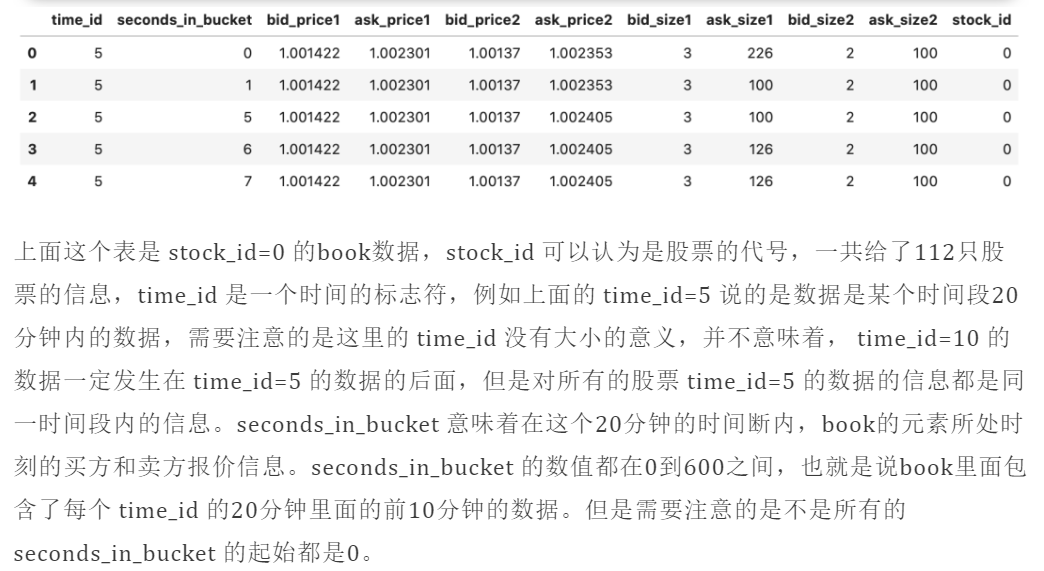

In [18]:
data = book_example.merge(trade_example,on=['time_id','seconds_in_bucket'],how='left')

In [20]:
data.isnull().sum()

time_id                0
seconds_in_bucket      0
bid_price1             0
ask_price1             0
bid_price2             0
ask_price2             0
bid_size1              0
ask_size1              0
bid_size2              0
ask_size2              0
stock_id_x             0
price                262
size                 262
order_count          262
stock_id_y           262
dtype: int64

## 读取数据

In [63]:
# data = clean.reduce_mem_usage(pd.read_parquet(path+'/train_book_trade.parquet'))
data.drop(['time_id'],axis=1,inplace=True)
# train = train.merge(train_trade_book,on=['stock_id','time_id'],how='left')

## lgb baseline

In [64]:
features = [col for col in data.columns if col not in ['row_id','target']]
# features

In [70]:
data.tail()

,stock_id,target,bid_price1_sum,bid_price1_mean,bid_price1_median,bid_price1_max,bid_price1_min,bid_price1_std,ask_price1_sum,ask_price1_mean,ask_price1_median,ask_price1_max,ask_price1_min,ask_price1_std,bid_price2_sum,bid_price2_mean,bid_price2_median,bid_price2_max,bid_price2_min,bid_price2_std,ask_price2_sum,ask_price2_mean,ask_price2_median,ask_price2_max,ask_price2_min,ask_price2_std,bid_size1_sum,bid_size1_mean,bid_size1_median,bid_size1_max,bid_size1_min,bid_size1_std,ask_size1_sum,ask_size1_mean,ask_size1_median,ask_size1_max,ask_size1_min,ask_size1_std,bid_size2_sum,bid_size2_mean,bid_size2_median,bid_size2_max,bid_size2_min,bid_size2_std,ask_size2_sum,ask_size2_mean,ask_size2_median,ask_size2_max,ask_size2_min,ask_size2_std,wap1_sum,wap1_mean,wap1_median,wap1_max,wap1_min,wap1_std,wap2_sum,wap2_mean,wap2_median,wap2_max,wap2_min,wap2_std,bid_amount1_sum,bid_amount1_mean,bid_amount1_median,bid_amount1_max,bid_amount1_min,bid_amount1_std,bid_amount2_sum,bid_amount2_mean,bid_amount2_median,bid_amount2_max,bid_amount2_min,bid_amount2_std,ask_amount1_sum,ask_amount1_mean,ask_amount1_median,ask_amount1_max,ask_amount1_min,ask_amount1_std,ask_amount2_sum,ask_amount2_mean,ask_amount2_median,ask_amount2_max,ask_amount2_min,ask_amount2_std,bid_price1-ask_price1_sum,bid_price1-ask_price1_mean,bid_price1-ask_price1_median,bid_price1-ask_price1_max,bid_price1-ask_price1_min,bid_price1-ask_price1_std,bid_price2-ask_price2_sum,bid_price2-ask_price2_mean,bid_price2-ask_price2_median,bid_price2-ask_price2_max,bid_price2-ask_price2_min,bid_price2-ask_price2_std,bid_size1-ask_size1_sum,bid_size1-ask_size1_mean,bid_size1-ask_size1_median,bid_size1-ask_size1_max,bid_size1-ask_size1_min,bid_size1-ask_size1_std,bid_size2-ask_size2_sum,bid_size2-ask_size2_mean,bid_size2-ask_size2_median,bid_size2-ask_size2_max,bid_size2-ask_size2_min,bid_size2-ask_size2_std,bid_amount1-ask_amount1_sum,bid_amount1-ask_amount1_mean,bid_amount1-ask_amount1_median,bid_amount1-ask_amount1_max,bid_amount1-ask_amount1_min,bid_amount1-ask_amount1_std,bid_amount2-ask_amount2_sum,bid_amount2-ask_amount2_mean,bid_amount2-ask_amount2_median,bid_amount2-ask_amount2_max,bid_amount2-ask_amount2_min,bid_amount2-ask_amount2_std,row_id
428927,126,0.003460,309.75,0.999023,0.999023,1.000000,0.998047,0.000549,310.000,1.000000,1.000000,1.000977,0.998535,0.000535,309.75,0.999023,0.999023,1.000000,0.997559,0.000566,310.000,1.000000,1.000000,1.000977,0.999023,0.000583,44673.0,144.106445,100.0,505,1,112.658653,24812.0,80.038712,25.5,353,1,95.808693,33603.0,108.396774,100.0,611,1,85.135117,22786.0,73.503227,100.0,349,1,64.328384,309.75,0.999512,0.999512,1.000977,0.998047,0.000628,309.75,0.999512,0.999512,1.000977,0.998047,0.000614,44623.675781,143.947342,99.951172,504.013672,0.998047,112.497330,33568.246094,108.284668,99.902344,609.806641,0.997559,85.042618,24812.177734,80.039284,25.524902,353.000000,0.999023,95.815933,22787.597656,73.508377,99.951172,349.000000,0.999512,64.332443,-0.268555,-0.000866,-0.000977,0.0,-0.001953,0.000379,-0.377930,-0.001219,-0.000977,-0.000488,-0.002441,0.000394,19861.0,64.067741,73.0,504,-345,156.837753,10817.0,34.893547,8.0,511,-344,103.858437,19811.500000,63.908066,72.810059,503.014160,-345.001953,156.711716,10780.650391,34.776291,7.978516,509.806641,-344.004883,103.779327,126-32751
428928,126,0.003113,223.50,1.001953,1.001953,1.004883,1.000977,0.001170,223.625,1.002930,1.002930,1.006836,1.000977,0.001382,223.50,1.001953,1.001953,1.004883,1.000977,0.001133,223.625,1.002930,1.002930,1.006836,1.000977,0.001399,20884.0,93.650223,20.0,505,1,114.999580,6602.0,29.605381,18.0,209,1,44.959606,20432.0,91.623322,100.0,293,1,75.943802,6343.0,28.443947,18.0,173,1,38.618313,223.50,1.001953,1.001953,1.006836,1.000977,0.001287,223.50,1.001953,1.001953,1.006836,1.000977,0.001280,20925.183594,93.834900,20.058594,506.479492,1.001953,115.233521,20473.878906,91.811119,100.097656,293.572266,1.000977,76.113647,6618.744141,29.680468,18.052734,209.204102,1.000977,45.061283,6

In [65]:
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [ ]:
X_train = data[~data['target'].isna()]
# X_test = data[data['target'].isna()]
y = X_train['target']

KF = KFold(n_splits=5, random_state=2021, shuffle=True)

params = {
          'objective':'regression',
          'metric':'rmse',
          'learning_rate':0.13,
          'subsample':0.9,
          'subsample_freq':5,
          'colsample_bytree':0.9,
#           'num_iterations': 200,
          'verbose':-1,
          'max_depth':7
          }

oof_lgb = np.zeros(len(X_train))
# predictions_lgb_age = np.zeros((len(X_test)))
# 特征重要性
feat_imp_df = pd.DataFrame({'feat': features, 'imp': 0})
# 五折交叉验证
for fold_, (trn_idx, val_idx) in enumerate(KF.split(X_train.values)):
    print("="*50+"{} fold".format(fold_+1)+"="*50)
    print('trn_idx:',trn_idx)
    print('val_idx:',val_idx)
    trn_weights = 1/np.square(y.iloc[trn_idx])
    val_weights = 1/np.square(y.iloc[val_idx])
    trn_data = lgb.Dataset(X_train.iloc[trn_idx][features],label=y.iloc[trn_idx]
                           ,categorical_feature=['stock_id'],weight=trn_weights)
    val_data = lgb.Dataset(X_train.iloc[val_idx][features],label=y.iloc[val_idx]
                           ,categorical_feature=['stock_id'],weight=val_weights)
    num_round = 1000
    evals_result = {} 
    clf = lgb.train(
        params,
        trn_data,
        num_round,
        valid_sets = [trn_data, val_data],
        verbose_eval=100,
        early_stopping_rounds=50,
#         categorical_feature=cate_cols
        feval=feval_rmspe,
        evals_result = evals_result
    )
    feat_imp_df['imp'] += clf.feature_importance() / 5
    oof_lgb[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
#     predictions_lgb_age[:] += clf_age.predict(X_test[features], num_iteration=clf_age.best_iteration)/5
print('rmspe score: %.4f'%rmspe(y,oof_lgb))

==================================================1 fold==================================================
trn_idx: [     0      1      2 ... 428929 428930 428931]
val_idx: [     3      5      8 ... 428914 428915 428921]
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.000463516	training's RMSPE: 0.341767	valid_1's rmse: 0.000477111	valid_1's RMSPE: 0.34348
[200]	training's rmse: 0.000449984	training's RMSPE: 0.3345	valid_1's rmse: 0.000473804	valid_1's RMSPE: 0.340145
[300]	training's rmse: 0.00044062	training's RMSPE: 0.330367	valid_1's rmse: 0.000473117	valid_1's RMSPE: 0.33909
[400]	training's rmse: 0.000432677	training's RMSPE: 0.327623	valid_1's rmse: 0.000472616	valid_1's RMSPE: 0.338935
Early stopping, best iteration is:
[377]	training's rmse: 0.000434381	training's RMSPE: 0.327901	valid_1's rmse: 0.000472704	valid_1's RMSPE: 0.338521
==================================================2 fold==================================================
t

In [67]:
feat_imp_df.sort_values(by = 'imp',ascending=False)

,feat,imp
0,stock_id,2964.4
91,bid_price2-ask_price2_sum,434.0
85,bid_price1-ask_price1_sum,322.4
60,wap2_std,284.2
86,bid_price1-ask_price1_mean,271.4
...,...,...
51,wap1_median,15.0
20,ask_price2_mean,14.4
50,wap1_mean,11.0
56,wap2_mean,8.0


In [13]:
graph = lgb.create_tree_digraph(clf, tree_index=1, name='Tree0')
graph.render(view=True)

'Tree0.gv.pdf'

* rmspe 0.3235
* rmspe 0.3146
* rmspe 0.3060 加入了stock_id
* rmspe 0.2998 将stock_id设置为类别变量

## 贝叶斯调参

In [22]:
def LGB_bayesian(
    num_leaves,  # int
     # int
    learning_rate,
       # int  
    feature_fraction,
    max_depth,
    bagging_fraction):
    
    # LightGBM expects next three parameters need to be integer. So we make them integer
    num_leaves = int(num_leaves)
#     min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)

    assert type(num_leaves) == int
#     assert type(min_data_in_leaf) == int
    assert type(max_depth) == int

    param = {
        'num_leaves': num_leaves,
#         'max_bin': 63,
#         'min_data_in_leaf': min_data_in_leaf,
        'learning_rate': learning_rate,
#         'min_sum_hessian_in_leaf': min_sum_hessian_in_leaf,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': 5,
        'feature_fraction': feature_fraction,
#         'lambda_l1': lambda_l1,
#         'lambda_l2': lambda_l2,
#         'min_gain_to_split': min_gain_to_split,
        'max_depth': max_depth,
#         'save_binary': True, 
        'seed': 2021,
        'feature_fraction_seed': 2021,
        'bagging_seed': 2021,
#         'drop_seed': 2021,
#         'data_random_seed': 2021,
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'rmse',
        'boost_from_average': False,   

    }    
    oof_lgb = np.zeros(len(X_train))
    for fold_, (trn_idx, val_idx) in enumerate(KF.split(X_train.values)):
        print("**************************************** {} fold**********************************".format(fold_))
        print('trn_idx:',trn_idx)
        print('val_idx:',val_idx)
        trn_data = lgb.Dataset(X_train.iloc[trn_idx][features],label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X_train.iloc[val_idx][features],label=y.iloc[val_idx])
        num_round = 1000
        clf = lgb.train(param, trn_data, num_round, valid_sets = [val_data],feval=feval_rmspe,verbose_eval=100, early_stopping_rounds = 50)
        oof_lgb[val_idx] = clf.predict(X_train.iloc[val_idx][features], num_iteration=clf.best_iteration)   

    score = rmspe(y,oof_lgb)
    
    return -score

In [24]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (20, 128), 
    'bagging_fraction':(0.6,1),
#     'min_data_in_leaf': (5, 20),  
    'learning_rate': (0.01, 0.3),
#     'min_sum_hessian_in_leaf': (0.00001, 0.01),    
    'feature_fraction': (0.6, 1),
#     'lambda_l1': (0, 5.0), 
#     'lambda_l2': (0, 5.0), 
#     'min_gain_to_split': (0, 2.0),
    'max_depth':(3,8),
}

In [25]:
from bayes_opt import BayesianOptimization
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=13)
print(LGB_BO.space.keys)

['bagging_fraction', 'feature_fraction', 'learning_rate', 'max_depth', 'num_leaves']


In [26]:
init_points = 5
n_iter = 10
bayesian_tr_index, bayesian_val_index  = list(KFold(n_splits=4, shuffle=True, random_state=1).split(X_train))[0]
print('-' * 130)
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | featur... | learni... | max_depth | num_le... |
-------------------------------------------------------------------------------------
**************************************** 0 fold**********************************
trn_idx: [     0      1      2 ... 428929 428930 428931]
val_idx: [     3      5      8 ... 428914 428915 428921]
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24234
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 108
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24321
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 108
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.00140232	valid_0's RMSPE: 0.30102
Early stopping, best iteration is:
[69]	valid_0's rmse: 0.00155589	valid_0's RMSPE: 0.289845
**************************************** 2 fold**********************************
trn_idx: [     0      3      4 ... 428928 428930 428931]
val_idx: [     1      2     18 ... 428912 428916 428929]
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24317
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 108
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 0.00140918	valid_0's RMSPE

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's rmse: 0.0013251	valid_0's RMSPE: 0.320912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[200]	valid_0's rmse: 0.00136025	valid_0's RMSPE: 0.354293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's rmse: 0.00137807	valid_0's RMSPE: 0.331802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[22]	valid_0's rmse: 0.00158591	valid_0's RMSPE: 0.304997
**************************************** 3 fold**********************************
trn_idx: [     0      1      2 ... 428928 428929 428931]
val_idx: [     4     10     13 ... 428924 428926 428930]
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24262
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't im

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

val_idx: [     4     10     13 ... 428924 428926 428930]
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.229224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24262
[LightGBM] [Info] Number of data points in the train set: 343146, number of used features: 108
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iter

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [27]:
LGB_BO.max['target']

-0.289000046056221

In [28]:
LGB_BO.max['params']

{'bagging_fraction': 0.6008553810821173,
 'feature_fraction': 0.6129430244479952,
 'learning_rate': 0.039156724434085896,
 'max_depth': 7.992083192787896,
 'num_leaves': 121.92124152988919}

In [88]:
int(LGB_BO.max['params']['max_depth'])

12

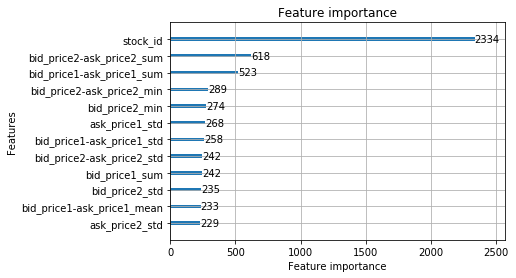

In [22]:
lgb.plot_importance(clf,max_num_features=12,importance_type='split')

In [99]:
graph = lgb.create_tree_digraph(clf, tree_index=0, name='Tree0')
graph.render(view=True)

'Tree0.gv.pdf'

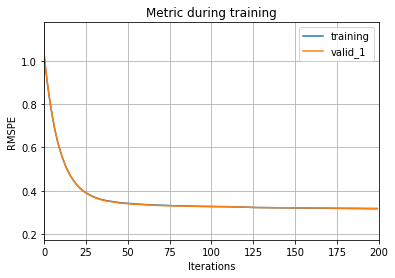

In [26]:
lgb.plot_metric(evals_result,metric='RMSPE')

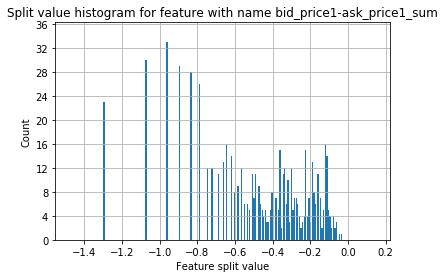

In [98]:
lgb.plot_split_value_histogram(clf,'bid_price1-ask_price1_sum')

In [ ]:
220